In [1]:
from __future__ import print_function
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from tensorboardX import SummaryWriter

from matplotlib import pyplot as plt

from tqdm import tqdm

batch_size = 128
epochs = 100
seed = 1
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
device = "cpu"

In [2]:
from Tars.distributions import RealNVP, Normal
from Tars.models import ML
from Tars.utils import get_dict_values

In [3]:
import torch
z_dim = 2

loc = torch.tensor(0.).to(device)
scale = torch.tensor(1.).to(device)
prior = Normal(loc=loc, scale=scale, var=["z"], dim=z_dim)

In [4]:
p = RealNVP(prior, var=["x"], in_features=z_dim, num_layers=2, hidden_features=32)

In [5]:
p.sample()

{'z': tensor([[-1.6528,  0.1216]]), 'x': tensor([[-1.9046,  0.1409]])}

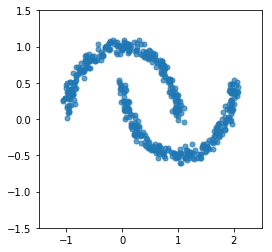

In [6]:
from sklearn.datasets import make_moons
points = make_moons(noise=.05, n_samples=10000)[0]

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
ax.scatter(points[:, 0][:500], points[:, 1][:500], alpha=0.7, s=25)
ax.set_xlim((-1.5, 2.5))
ax.set_ylim((-1.5, 1.5))

plt.show()

In [7]:
x = torch.FloatTensor(points)

In [8]:
model = ML(p, optim.Adam, {"lr":1e-3})

In [ ]:
batch_size = 500
for epoch in range(1000):
    for i in range(int(len(x)/batch_size)):
        batch_x = x[batch_size*i:batch_size*(i+1)]
        lower_bound, loss = model.train({"x":batch_x})
    if epoch % 10 == 0:
        lower_bound, loss = model.test({"x":x})
        print("Loss {}: {}".format(epoch , loss.data))

Loss 0: 1.9152119159698486
Loss 10: 1.217727780342102
Loss 20: 0.8873106837272644
Loss 30: 0.5786476135253906
Loss 40: 0.48461511731147766
Loss 50: 0.4424678087234497
Loss 60: 0.4213637113571167
Loss 70: 0.40586015582084656
Loss 80: 0.39337602257728577
Loss 90: 0.38791704177856445
Loss 100: 0.3818158507347107
Loss 110: 0.37421849370002747
Loss 120: 0.3717253804206848
Loss 130: 0.3676304221153259
Loss 140: 0.3624877631664276
Loss 150: 0.35921579599380493
Loss 160: 0.3593675494194031
Loss 170: 0.3578243553638458
Loss 180: 0.35605326294898987
Loss 190: 0.3545977473258972
Loss 200: 0.3544066846370697
Loss 210: 0.35400161147117615
Loss 220: 0.35241177678108215
Loss 230: 0.35245347023010254
Loss 240: 0.35247644782066345
Loss 250: 0.3486308753490448
Loss 260: 0.3495139479637146
Loss 270: 0.3493964374065399
Loss 280: 0.3503069579601288
Loss 290: 0.347149521112442
Loss 300: 0.3466913104057312
Loss 310: 0.3454349935054779
Loss 320: 0.34701284766197205
Loss 330: 0.34683963656425476
Loss 340: 0.34

torch.Size([500, 2])


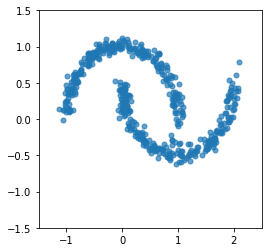

In [31]:
samples = p.sample(batch_size=500)
points = samples["x"].data

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
ax.scatter(points[:, 0], points[:, 1], alpha=0.7, s=25)
ax.set_xlim((-1.5, 2.5))
ax.set_ylim((-1.5, 1.5))

plt.show()